In [1]:
import jsonlines
import os
import json
import glob
import numpy as np
import pathlib
from numpy import load
import torch
import lovely_tensors as lt
lt.monkey_patch()
import tqdm
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

# DEBUGGING 
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

/home/kastan/utils/miniconda3/envs/custom_huggingface/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dir_name = "parallel_15"
REMOTE_WHISPER_FILE = f'/mnt/storage_hdd/thesis/yt_1b_dataset/yt_1b_train/{dir_name}_whisper_output.jsonl'
REMOTE_CLIP_DIR  = f'/mnt/storage_hdd/thesis/yt_1b_dataset/yt_1b_train/{dir_name}_clip_output'
REMOTE_SCENE_FILE = f'/mnt/storage_hdd/thesis/yt_1b_dataset/yt_1b_train/{dir_name}_scene_output.jsonl'

In [4]:
# Instantiate clip
import clip

MODEL_SIZE = 'ViT-L/14@336px'  # Best models are (1st) ViT-L/14@336px and (2nd) ViT-L/14. I don't recommend going lower.  
clip_instance, clip_preprocess = clip.load(MODEL_SIZE, device)

In [4]:
from transformers import GPT2Tokenizer, OPTForCausalLM
t5 = OPTForCausalLM.from_pretrained("facebook/opt-125m").to(device)
t5_tokenizer = GPT2Tokenizer.from_pretrained("facebook/opt-125m")

learning_rate       = 1e-4  # also good: 3e-4
optimizer = torch.optim.AdamW(params =  t5.parameters(), lr=learning_rate) # Typically, 1e-4 and 3e-4 work well for most problems

# prompt = "Hey, are you consciours? Can you talk to me?"
# inputs = tokenizer(prompt, return_tensors="pt")

# # Generate
# generate_ids = model.generate(inputs.input_ids, max_length=30)
# tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

In [ ]:
from transformers import RobertaForCausalLM, RobertaTokenizer
MODEL_NAME = "roberta-base"
t5 = RobertaForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=torch.float32, low_cpu_mem_usage=False).to(device) # float16, True
t5_tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME, return_special_tokens_mask=True)

In [4]:
# T5
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Model, T5Config, AutoModelWithLMHead

'''
MODEL SELECTION

T5 V1.1 --  https://huggingface.co/docs/transformers/model_doc/t5v1.1 && https://github.com/google-research/text-to-text-transfer-transformer/blob/main/released_checkpoints.md#t511
small - base - large - 3b/xl - 11b/xxl

OG: t5-small

'google/t5-base-lm-adapt' # largest on my server (without float16)
'google/t5-xl-lm-adapt'

google/t5-v1_1-large
'''

# MODEL_SIZE = "t5-base"
MODEL_NAME = "google/t5-v1_1-base"
# MODEL_NAME = "google/t5-base-lm-adapt"
# config = T5Config.from_pretrained(MODEL_NAME)
t5 = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, torch_dtype=torch.float32, low_cpu_mem_usage=False).to(device) # float16, True
t5_tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME, return_special_tokens_mask=True)
# low_cpu_mem_usage(bool, optional) — Tries to not use more than 1x model size in CPU memory (including peak memory) while loading the model. experimental.
learning_rate       = 1e-4  # also good: 3e-4
optimizer = torch.optim.AdamW(params =  t5.parameters(), lr=learning_rate) # Typically, 1e-4 and 3e-4 work well for most problems


In [5]:
type(t5.lm_head)

torch.nn.modules.linear.Linear

In [ ]:
# Cockpit ML Debugger
# https://cockpit.readthedocs.io/en/latest/examples/01_basic_fmnist.html
from backpack import extend
from cockpit import Cockpit, CockpitPlotter
from cockpit.utils.configuration import configuration

t5 = extend(t5)

individual_loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-100)

# Create Cockpit and a plotter
cockpit = Cockpit(t5.parameters(), quantities=configuration("full"))
plotter = CockpitPlotter()

In [ ]:
''' just for trying the debugger cockpit'''


# Iterate through the batch
clip_15 = os.listdir(REMOTE_CLIP_DIR)

# Initialize embeddings
one_input_shape = [1, 768, 768]
att_mask_shape = [1, 768]
embed_shape = [1, 768]

input_embeds_arr = torch.zeros(one_input_shape).to(device) # .astype(np.float16)
attn_mask_arr    = torch.zeros(att_mask_shape).to(device)
attn_mask_arr[0][0] = 1
attn_mask_arr[0][1] = 1
attn_mask_arr[0][2] = 1 # no clip

t5.train()

global_step = 0 

with jsonlines.open(REMOTE_SCENE_FILE, 'r') as scene_reader:
    # Zipping the scene graph with the clip + whisper embeddings
    
    # itr over videos
    for scene_seg_list, clip_npz_path in tqdm.tqdm(zip(scene_reader, glob.glob(os.path.join(REMOTE_CLIP_DIR, '*'), recursive = True))):
        try:
            np_loaded = np.load(clip_npz_path, allow_pickle=True)
        except Exception as e:
            print(f"Failed to load compressed numpy: {e}")
            continue
        object_list_of_str = []
        scene_seg_list = json.loads(scene_seg_list)
        
        # iterate over segments
        for segment_index in range(np_loaded['arr_0'].item()['total_segments']):
            # print(np_loaded[f'arr_{segment_index}'].item()['captions'])
            frame_embedding       = np_loaded[f'arr_{segment_index}'].item()['frame_embeddings']
            caption_embedding     = np_loaded[f'arr_{segment_index}'].item()['text_caption_embeddings']
            whisper_text_captions = np_loaded[f'arr_{segment_index}'].item()['captions']
            
            frame_embedding       = torch.from_numpy(frame_embedding.reshape((768,))).to(device)
            caption_embedding     = torch.from_numpy(caption_embedding).to(device)

            # Update embedding array
            input_embeds_arr[0][0] = frame_embedding
            input_embeds_arr[0][1] = caption_embedding
            
            # print("Input shapes:")
            # print(caption_embedding)
            print(frame_embedding)
            labels = t5_tokenizer(whisper_text_captions, return_tensors="pt").input_ids.to(device)
            # outputs = t5.forward(inputs_embeds=input_embeds_arr, attention_mask=attn_mask_arr, decoder_inputs_embeds=input_embeds_arr)
            outputs = t5.forward(inputs_embeds=input_embeds_arr, attention_mask=attn_mask_arr, labels=labels, return_dict=True)
            # outputs = t5.forward(inputs_embeds=input_embeds_arr, labels=labels)
            loss = outputs[0]
            print("loss")
            print(loss)
            logits = outputs[1]
            # print("logits")
            # print(logits)
            individual_losses = individual_loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))
            # print("individual_losses")
            # print(individual_losses)
            # loss = 
            for item in outputs:
                print(item)
            ''' backwards pass '''
            # loss.sum().backward()
            # backward pass
            with cockpit(
                global_step,
                info={
                    "batch_size": one_input_shape[0],
                    "individual_losses": individual_losses,
                    "loss": loss,
                    "optimizer": optimizer,
                },
            ):
                loss.backward(create_graph=cockpit.create_graph(global_step))
            
            # optimizer step
            optimizer.zero_grad()
            optimizer.step()
            global_step += 1
            print(f"step: {global_step}")
            plotter.plot(cockpit)
            
            print("Loss 👇👇👇")
            print(loss)
            break
        break


In [ ]:
# from transformers import RobertaConfig
# OPTConfig.from_pretrained("roberta-base")
from transformers import OPTConfig
OPTConfig.from_pretrained("facebook/opt-125m")

In [ ]:
''' More complete '''

# Initialize embeddings
# one_input_shape = [1, 768, 768]
# att_mask_shape = [1, 768]
# embed_shape = [1, 768]
one_input_shape = [1, 2048, 768]  # torch.FloatTensor of shape (batch_size, sequence_length, hidden_size)
att_mask_shape = [1, 2048]        # 
embed_shape = [1, 768]

input_embeds_arr = torch.zeros(one_input_shape, device=device)
attn_mask_arr    = torch.zeros(att_mask_shape, device=device)
labels    = torch.zeros(att_mask_shape, dtype=int, device=device)
print(labels.dtype)
labels[:len(labels)] = -100
attn_mask_arr[0][0] = 1
attn_mask_arr[0][1] = 1
# attn_mask_arr[0][2] = 1 # no clip

t5.train()

global_step = 0 

with jsonlines.open(REMOTE_SCENE_FILE, 'r') as scene_reader:
    # Zipping the scene graph with the clip + whisper embeddings
    # itr over videos
    for scene_seg_list, clip_npz_path in tqdm.tqdm(zip(scene_reader, glob.glob(os.path.join(REMOTE_CLIP_DIR, '*'), recursive = True))):
        try:
            np_loaded = np.load(clip_npz_path, allow_pickle=True)
        except Exception as e:
            print(f"Failed to load compressed numpy: {e}")
            continue
        object_list_of_str = []
        scene_seg_list = json.loads(scene_seg_list)
        
        # iterate over segments
        for segment_index in range(np_loaded['arr_0'].item()['total_segments']):
            frame_embedding       = np_loaded[f'arr_{segment_index}'].item()['frame_embeddings']
            caption_embedding     = np_loaded[f'arr_{segment_index}'].item()['text_caption_embeddings']
            whisper_text_captions = np_loaded[f'arr_{segment_index}'].item()['captions']
            
            frame_embedding       = torch.from_numpy(frame_embedding.reshape((768,))).to(device)
            caption_embedding     = torch.from_numpy(caption_embedding).to(device)

            scene_caption = scene_seg_list[segment_index]
            scene_caption = clip.tokenize(scene_caption).to(device)
            with torch.inference_mode(): # even faster than no_grad()
                scene_embedding = clip_instance.encode_text(scene_caption)
            scene_embedding = scene_embedding.reshape((768,))

            # Update embedding array
            input_embeds_arr[0][0] = frame_embedding
            input_embeds_arr[0][1] = caption_embedding
            input_embeds_arr[0][2] = scene_embedding
            
            print("Input shapes:")
            print(input_embeds_arr.shape)
            print(scene_embedding.shape)
            print(caption_embedding.shape)
            print(frame_embedding.shape)
            tokenized_labels = t5_tokenizer(whisper_text_captions, return_tensors="pt").input_ids.to(device)
            print("tokenized_labels")
            print(tokenized_labels)
            print("labels")
            print(labels)
            print(labels.dtype)
            labels[0][0:len(tokenized_labels[0])] = tokenized_labels[0]
            # outputs = t5.forward(inputs_embeds=input_embeds_arr, attention_mask=attn_mask_arr, decoder_inputs_embeds=input_embeds_arr)
            # outputs = t5.forward(inputs_embeds=input_embeds_arr, attention_mask=attn_mask_arr, labels=labels, return_dict=True)
            # outputs = t5.forward(inputs_embeds=input_embeds_arr, labels=labels)
            outputs = t5.forward(inputs_embeds=input_embeds_arr, attention_mask=attn_mask_arr, labels=labels, return_dict=True, return_last_hidden_state=True)
            print(outputs['last_hidden_state'].shape)
            
            results = t5.lm_head(outputs['last_hidden_state'])
            print(results)
            # loss = outputs[0]
            # ''' backwards pass '''
            # loss.sum().backward()
            # # optimizer step
            # optimizer.zero_grad()
            # optimizer.step()
            # global_step += 1
            print(f"step: {global_step}")
            
            print("Loss 👇👇👇")
            print(loss)
            break
        break


In [9]:
''' More complete -- NO CLIP (for convienence) '''

# Initialize embeddings
one_input_shape = [1, 768, 768]
att_mask_shape = [1, 768]
embed_shape = [1, 768]
# one_input_shape = [1, 2048, 768]  # torch.FloatTensor of shape (batch_size, sequence_length, hidden_size)
# att_mask_shape = [1, 2048]        # 
# embed_shape = [1, 768]

input_embeds_arr = torch.zeros(one_input_shape, device=device)
attn_mask_arr    = torch.zeros(att_mask_shape, device=device)
labels    = torch.zeros(att_mask_shape, dtype=int, device=device)
print(labels.dtype)
labels[:len(labels)] = -100
attn_mask_arr[0][0] = 1
attn_mask_arr[0][1] = 1
# attn_mask_arr[0][2] = 1 # no clip

t5.train()

global_step = 0 

with jsonlines.open(REMOTE_SCENE_FILE, 'r') as scene_reader:
    # Zipping the scene graph with the clip + whisper embeddings
    # itr over videos
    for scene_seg_list, clip_npz_path in tqdm.tqdm(zip(scene_reader, glob.glob(os.path.join(REMOTE_CLIP_DIR, '*'), recursive = True))):
        try:
            np_loaded = np.load(clip_npz_path, allow_pickle=True)
        except Exception as e:
            print(f"Failed to load compressed numpy: {e}")
            continue
        object_list_of_str = []
        scene_seg_list = json.loads(scene_seg_list)
        
        # iterate over segments
        for segment_index in range(np_loaded['arr_0'].item()['total_segments']):
            frame_embedding       = np_loaded[f'arr_{segment_index}'].item()['frame_embeddings']
            caption_embedding     = np_loaded[f'arr_{segment_index}'].item()['text_caption_embeddings']
            whisper_text_captions = np_loaded[f'arr_{segment_index}'].item()['captions']
            
            frame_embedding       = torch.from_numpy(frame_embedding.reshape((768,))).to(device)
            caption_embedding     = torch.from_numpy(caption_embedding).to(device)

            scene_caption = scene_seg_list[segment_index]
            # scene_caption = clip.tokenize(scene_caption).to(device)
            # with torch.inference_mode(): # even faster than no_grad()
                # scene_embedding = clip_instance.encode_text(scene_caption)
            # scene_embedding = scene_embedding.reshape((768,))

            # Update embedding array
            input_embeds_arr[0][0] = frame_embedding
            input_embeds_arr[0][1] = caption_embedding
            # input_embeds_arr[0][2] = scene_embedding
            
            print("Input shapes:")
            print(input_embeds_arr.shape)
            # print(scene_embedding.shape)
            print(caption_embedding.shape)
            print(frame_embedding.shape)
            tokenized_labels = t5_tokenizer(whisper_text_captions, return_tensors="pt").input_ids.to(device)
            print("tokenized_labels")
            print(tokenized_labels)
            print("labels")
            print(labels)
            print(labels.dtype)
            labels[0][0:len(tokenized_labels[0])] = tokenized_labels[0]
            # outputs = t5.forward(inputs_embeds=input_embeds_arr, attention_mask=attn_mask_arr, decoder_inputs_embeds=input_embeds_arr)
            # outputs = t5.forward(inputs_embeds=input_embeds_arr, attention_mask=attn_mask_arr, labels=labels, return_dict=True)
            # outputs = t5.forward(inputs_embeds=input_embeds_arr, labels=labels)
            
            decoder_input_ids = t5.forward()
            output_ids = t5.generate(attention_mask=attn_mask_arr, decoder_input_ids=decoder_input_ids, inputs_embeds=input_embeds_arr, max_length=100, num_beams=4)

            outputs = t5.forward(inputs_embeds=input_embeds_arr, attention_mask=attn_mask_arr, labels=labels, return_dict=True, output_hidden_states=True)
            print(outputs['last_hidden_state'].shape)
            
            results = t5.lm_head(outputs['last_hidden_state'])
            print(results)
            # loss = outputs[0]
            # ''' backwards pass '''
            # loss.sum().backward()
            # # optimizer step
            # optimizer.zero_grad()
            # optimizer.step()
            # global_step += 1
            print(f"step: {global_step}")
            
            print("Loss 👇👇👇")
            print(loss)
            break
        break


torch.int64


0it [00:00, ?it/s]

Input shapes:
torch.Size([1, 768, 768])
torch.Size([768])
torch.Size([768])
tokenized_labels
tensor[1, 33] i64 x∈[1, 25000] μ=6.060e+03 σ=8.433e+03
labels
tensor[1, 768] i64 x∈[-100, -100] μ=-100.000 σ=0.
torch.int64


0it [00:07, ?it/s]


KeyError: 'last_hidden_state'

In [21]:
tokenized_labels

tensor[1, 33] i64 x∈[1, 25000] μ=6.060e+03 σ=8.433e+03

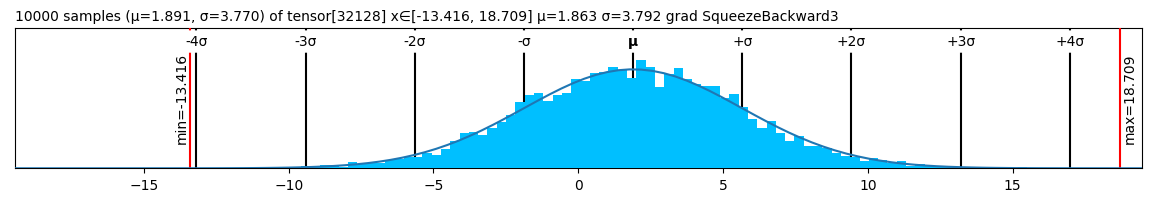

In [30]:
res = t5.lm_head(outputs['encoder_last_hidden_state'][0][0], shared_embedding=t5.shared)
res.plt()

In [31]:
t5.get_output_layer_with_bias()

AttributeError: 'T5ForConditionalGeneration' object has no attribute 'get_output_layer_with_bias'

In [32]:
outputs['encoder_last_hidden_state']

tensor[1, 768, 768] n=589824 x∈[-3.743, 3.480] μ=0.008 σ=0.221 grad MulBackward0

In [36]:
decoder_input_ids = outputs['encoder_last_hidden_state']
output_ids = t5.generate(attention_mask=attn_mask_arr, inputs_embeds=input_embeds_arr, max_length=768, num_beams=4)

In [41]:
print(t5_tokenizer.decode(output_ids[0], skip_special_tokens=True))

leyedge  beCy


In [28]:
outputs['encoder_last_hidden_state']

for i in range(40):
  print(i, "  ",outputs['encoder_last_hidden_state'][0][i])
  # display(outputs['encoder_last_hidden_state'][0][i].plt)

0    tensor[768] x∈[-0.641, 0.664] μ=0.004 σ=0.206 grad SelectBackward0
1    tensor[768] x∈[-0.819, 1.895] μ=0.005 σ=0.262 grad SelectBackward0
2    tensor[768] x∈[-1.212, 2.202] μ=0.010 σ=0.257 grad SelectBackward0
3    tensor[768] x∈[-1.842, 1.446] μ=0.011 σ=0.268 grad SelectBackward0
4    tensor[768] x∈[-0.780, 0.905] μ=0.011 σ=0.253 grad SelectBackward0
5    tensor[768] x∈[-0.409, 0.526] μ=0.006 σ=0.054 grad SelectBackward0
6    tensor[768] x∈[-2.017, 2.062] μ=0.012 σ=0.269 grad SelectBackward0
7    tensor[768] x∈[-1.222, 2.248] μ=0.013 σ=0.253 grad SelectBackward0
8    tensor[768] x∈[-0.950, 0.782] μ=-0.006 σ=0.121 grad SelectBackward0
9    tensor[768] x∈[-0.368, 0.582] μ=0.007 σ=0.076 grad SelectBackward0
10    tensor[768] x∈[-1.840, 1.745] μ=0.003 σ=0.276 grad SelectBackward0
11    tensor[768] x∈[-1.417, 1.333] μ=0.007 σ=0.256 grad SelectBackward0
12    tensor[768] x∈[-0.878, 0.971] μ=-0.002 σ=0.154 grad SelectBackward0
13    tensor[768] x∈[-1.169, 0.972] μ=0.014 σ=0.153 grad Se

In [ ]:
# t5.save_pretrained("BIG_PENIS_PREVAILS")

In [ ]:
labels[0][0:27]
# len(tokenized_labels)

# Trying Inference with custom model

import jsonlines
import os
import json
import glob
import numpy as np
import pathlib
from numpy import load
import lovely_tensors as lt
lt.monkey_patch()
import tqdm

import jsonlines
import os
import json
import glob
import numpy as np
import pathlib
from numpy import load
import lovely_tensors as lt
lt.monkey_patch()
import tqdm

In [1]:
import jsonlines
import os
import json
import glob
import numpy as np
import pathlib
from numpy import load
import torch
import lovely_tensors as lt
lt.monkey_patch()
import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

/home/kastan/utils/miniconda3/envs/custom_huggingface/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# LOAD FINE-TUNED T5
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Model, T5Config
from transformers import AutoTokenizer, AutoModelWithLMHead
from transformers import OPTForCausalLM

# MODEL_VERSION_NAME   = "opt_yt_pretrain_adamW_1e-3_iter69000"
# TOKENIZER_NAME       = "facebook/opt-125m"

# BASE_DIR            = '/scratch/bbki/kastanday/whisper'
# BASE_DIR            = '/mnt/storage_hdd/thesis/yt_1b_dataset/yt_1b_train'
# MODEL_SAVE_PATH     = f'{BASE_DIR}/MODEL_CHECKPOINTS/{MODEL_VERSION_NAME}'

TOKENIZER_NAME       = "google/t5-v1_1-base"
t5     = AutoModelWithLMHead.from_pretrained("/mnt/storage_hdd/thesis/MODEL_CHECKPOINTS/T5_labels_are_half_batch_15_adamW_iter622500").to(device)
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)

In [10]:
# Instantiate clip
import clip

MODEL_SIZE = 'ViT-L/14@336px'  # Best models are (1st) ViT-L/14@336px and (2nd) ViT-L/14. I don't recommend going lower.  
clip_instance, clip_preprocess = clip.load(MODEL_SIZE, device)

In [11]:
# get standard image and embed with CLIP.
import deeplake as dl
clip_dataset_path = f'/mnt/storage_ssd/dummy_clip_results_parallel_15'
ds = dl.load(clip_dataset_path)
print(ds.summary())

frame_embedding = ds.pooled_clip_embedding[0].numpy()
frame_embedding.shape

/mnt/storage_ssd/dummy_clip_results_parallel_15 loaded successfully.
Dataset(path='/mnt/storage_ssd/dummy_clip_results_parallel_15', tensors=['caption', 'clip_hidden_states', 'pooled_clip_embedding', 'segment_metadata', 'video_filename', 'video_filepath'])

        tensor           htype       shape        dtype  compression
        -------         -------     -------      -------  ------- 
        caption          text      (17185, 1)      str     None   
  clip_hidden_states     image   (68740, 1:768)  float32    lz4   
 pooled_clip_embedding   image   (68740, 1:768)  float32    lz4   
   segment_metadata      json      (16748, 1)      str      lz4   
    video_filename       text      (17185, 1)      str     None   
    video_filepath       text      (17185, 1)      str     None   
None


(768,)

In [17]:
# PROMPT = "Hey guys welcome back to the channel, "
# PROMPT = "I REALLY LIKE EATING ASS"
# PROMPT = "TODAY WE ARE GOING TO"
PROMPT = "IN THIS VIDEO WE WILL"
# PROMPT = "THE MOST COMMON WORD IN THE ENGLISH LANGUAGE"
# PROMPT = "IN THIS VIDEO WE WILL"
# PROMPT = "I LOVE VIDEO GAMES BECAUSE I LOVE KILLING"
PROMPT = "The secret to cooking a good burrito is"


# OLD/naive inference
# input_ids = tokenizer(PROMPT, return_tensors="pt").input_ids
# outputs = model.generate(input_ids)
# print(tokenizer.decode(outputs[0]))


# Initialize embeddings
one_input_shape = [1, 768, 768]
att_mask_shape = [1, 768]
input_embeds_arr = torch.zeros(one_input_shape, device=device)
attn_mask_arr    = torch.zeros(att_mask_shape, device=device)
# labels    = torch.zeros(att_mask_shape, dtype=int, device=device)
# labels[:] = -100

# device = 'cpu'
caption_tokenized = clip.tokenize(PROMPT).to(device)
with torch.inference_mode():
    caption_embedding = clip_instance.encode_text(caption_tokenized)
caption_embedding = caption_embedding.reshape((768,))

attn_mask_arr[0][0] = 1
attn_mask_arr[0][1] = 1
attn_mask_arr[0][2] = 1
input_embeds_arr[0][0] = torch.tensor(frame_embedding)
input_embeds_arr[0][1] = caption_embedding
input_embeds_arr[0][2] = caption_embedding

# TODO: generate attn_mask_arr, input_embeds_arr

output_ids = t5.generate(attention_mask=attn_mask_arr, inputs_embeds=input_embeds_arr, max_length=768, num_beams=10)
print(tokenizer.decode(output_ids[0], skip_special_tokens=True))

tie, bottle on counter, bottle on counter


/mnt/storage_ssd/dummy_clip_results_parallel_15 loaded successfully.
Dataset(path='/mnt/storage_ssd/dummy_clip_results_parallel_15', tensors=['caption', 'clip_hidden_states', 'pooled_clip_embedding', 'segment_metadata', 'video_filename', 'video_filepath'])

        tensor           htype       shape        dtype  compression
        -------         -------     -------      -------  ------- 
        caption          text      (17185, 1)      str     None   
  clip_hidden_states     image   (68740, 1:768)  float32    lz4   
 pooled_clip_embedding   image   (68740, 1:768)  float32    lz4   
   segment_metadata      json      (16748, 1)      str      lz4   
    video_filename       text      (17185, 1)      str     None   
    video_filepath       text      (17185, 1)      str     None   
None


(768,)

(768,)

# Trying GPT-2

from transformers import GPT2Tokenizer, GPT2Model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

In [1]:
from transformers import GPT2Tokenizer, GPT2Model, GPT2Config

/home/kastan/utils/miniconda3/envs/general_has_everything/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
GPT2Config.from_pretrained('gpt2')

GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.24.0",
  "use_cache": true,
  "vocab_size": 50257
}

In [15]:
scene_caption = '1123 2 3 4 5 6 7'.split(" ")
import itertools
first_half_of_whisper_caption  = list(itertools.islice(scene_caption, 0, len(scene_caption)//2))
second_half_of_whisper_caption = list(itertools.islice(scene_caption, len(scene_caption)//2, None))
" ".join(first_half_of_whisper_caption)

'1123 2 3'

In [13]:
second_half_of_whisper_caption

['4', '5', '6', '7']

In [20]:
n = len(scene_caption)//2
parts = [scene_caption[i:i+n] for i in range(0, len(scene_caption), n)]
parts

[['1123', '2', '3'], ['4', '5', '6'], ['7']]